# Operações Morfológicas

Muitas vezes o resultado de uma segmentação por mascaramento não sai exatamente como queríamos.


Para imagens coloridas, o mais comum é trabalhar no espaço de cores **HSV - Hue, Saturation, Value**, onde o canal H (matiz) indica o valor da cor dentro dos círculos de cores básicas. No OpenCV, o canal Hue é representado através da metade do ângulo em graus no círculo de cores. Assim os valores variam de 0 a 180, o que cabe numa representação de 8 bits.

![](color_wheel.png)

**Exemplo:** vamos detectar apenas a cor violeta na imagem `cores.jpg`. Vamos assumir que a cor violeta encontra-se na faixa de 260º a 280º no círculo de cores  

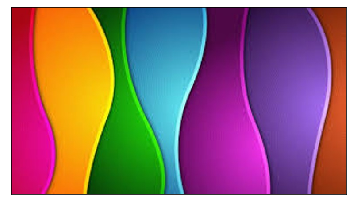

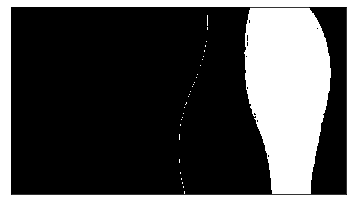

In [6]:
imgcor = cv2.imread("cores.jpg", cv2.IMREAD_COLOR)
mostra_fig(imgcor)
# Faz a conversão para o espaço HSV
img_hsv = cv2.cvtColor(imgcor, cv2.COLOR_BGR2HSV)
# Pega apenas o primeiro canal da imagem
canal_hue = img_hsv[:,:,0]
# Segmenta apenas a cor violeta no canal Hue
menor = int(260/2)
maior = int(280/2)
mask_violeta = cv2.inRange(canal_hue, menor, maior)
mostra_fig(mask_violeta)


### Pratique: 
Carregar a imagem `pingpong.jpg` e crie uma máscara indicando os pixels pertencentes à bolinha de pingue-pongue



In [7]:
img = cv2.imread("pingpong.jpg", cv2.IMREAD_COLOR)
# continuar...
 

# Operações morfológicas

Podemos reparar dos exemplos anteriores que muitas vezes as máscaras obtidas aparecem com *buracos* e/ou *ilhas*, de forma que:
- **Buracos** são pequenos segmentos de pixels pretos dentro de regiões de pixels brancos
- **Ilhas** são pequenos segmentos de pixels brancos dentro de regiões de pixels pretos.

Em geral, buracos e ilhas são regiões onde houve falha na segmentação da imagem. Para tratar imagfens com esses problemas,
a área de processamento de imagens usa um conjunto de técnicas conhecidas como *Morfologia Matemática*. Elas surgiram no problema de análise da estrutira de cristais, mas obtiveram muito sucesso na área de processamento de imagens.

As operações de morfologia matemática se baseima na ideia de um elemento estruturante, que podemos pensar em uma pequena janela quadrada, com as dimensões de poucos pixels, que vasculham a imagem realizando uma de duas operações básicas:

1. **Erosão:**  ao encontrar um pixel preto dentro da janela, todos os pixels que estão dentro dessa janela ficam pretos

![](erodbin.gif)

https://homepages.inf.ed.ac.uk/rbf/HIPR2/erode.htm (exemplo com elemento estruturante 3x3)

![](erosion_j.png)

2. Dilatação: ao encontrar um pixel branco dentro da janela, todos os pixels que estão dentro dessa janela ficam brancos

![](diltbin.gif)

https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm (exemplo com elemento estruturante 3x3)

![](dilation_j.png)


A partir dessas duas operações, diversas outras são possíveis. Dessas, operações que encontram bastante utilidade prática em processamento de imagens é a de *abertura* e *fechamento*. 

### Abertura
Na operação de abertura são realizadas as operações de erosão e depois de dilatação. A ideia é eliminar pequenas ilhas, que seriam eliminadas na erosão, e depois restaurar as dimensões dos agrupamentos brancos restantes. Vamos ver um exemplo de uso da abertura na máscara em que identificamos os trechos de cor violeta     


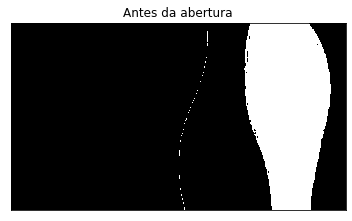

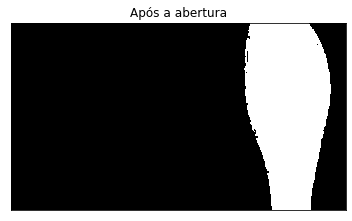

In [8]:
# Cria uma janela 3x3 como elemento estruturante
import numpy as np
elemento_estrut = np.ones([3,3])
# realiza a abertura
mask_violeta_abertura = cv2.morphologyEx(mask_violeta, cv2.MORPH_OPEN, elemento_estrut)
mostra_fig(mask_violeta, "Antes da abertura")
mostra_fig(mask_violeta_abertura, "Após a abertura")



### Fechamento
Na operação de fechamento são realizadas as operações de dilatação e depois de erosão. A ideia é fechar pequenos buracos, que seriam eliminadas na silatação, e depois restaurar as dimensões dos agrupamentos restantes. Vamos ver um exemplo de uso do fechamento na máscara em que identificamos os trechos de cor violeta

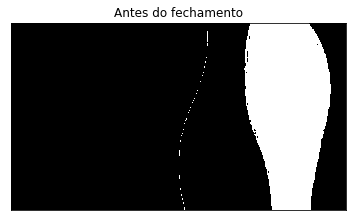

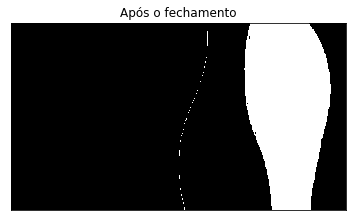

In [9]:
# Cria uma janela 3x3 como elemento estruturante
import numpy as np
elemento_estrut = np.ones([3,3])
# realiza a abertura
mask_violeta_fechamento = cv2.morphologyEx(mask_violeta, cv2.MORPH_CLOSE, elemento_estrut)
mostra_fig(mask_violeta, "Antes do fechamento")
mostra_fig(mask_violeta_fechamento, "Após o fechamento")

### Pratique: 
Qual seria o resultado da aplicação da abertura seguida do fechamento na máscara usada acima?

## Componentes conexos

Após a segmentação da imagem por mascaramento, podemos observar que os pixels de interesse podem formar um ou mais grupos conectados entre si, ou seja, conjuntos de pixels que se comunicam através de algum caminho que passa apenas por pixels de interesse (brancos)

![](retangulos.bmp) -> ![](retangulos_mask.bmp) -> ![](retangulos_ccomp.bmp)

No OpenCV, é possível encontrar componente conexos em imagens tons de cinza através da função `cv2.findContours()`. Ela considera pixels de valor maior do que 0 como pixels de interesse. 

Usamos a função da forma:

```
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
```
onde:
- `mask` é a imagem com a máscara binária
- `cv2.RETR_CCOMP` indica que queremos organizar os contornos em componentes conexos e buracos dentro deles
- `cv2.CHAIN_APPROX_NONE` indica que queremos armazenar todos os pontos do contorno
- `contours` é uma lista de contornos, contendo os pontos a ele pertencententes
- `hierarchy` é uma lista indicando a organização dos contornos em termos dos componentes e de seus buracos


Os componentes conexos são representados através de seus contornos internos, ou seja, dos pixels de cada componente conexo que são vizinhos a pixels de fundo. Para desenhar os contornos em uma imagem, usamos a função `cv2.drawContours()`, que usamos da forma:

```
cv2.drawContours(imagem, contours, indice, cor)
```
- `imagem` é a imagem colorida ou tons de cinza a receber o contorno
- `contours` é a lista de contornos obtida com `cv2.findContours()`
- `indice` é o índice do contorno dentro da lista a ser desenhado; se indice < 0 desenha todos os contornos
- `cor` é a cor do pixel a ser usada para desenhar o contorno   



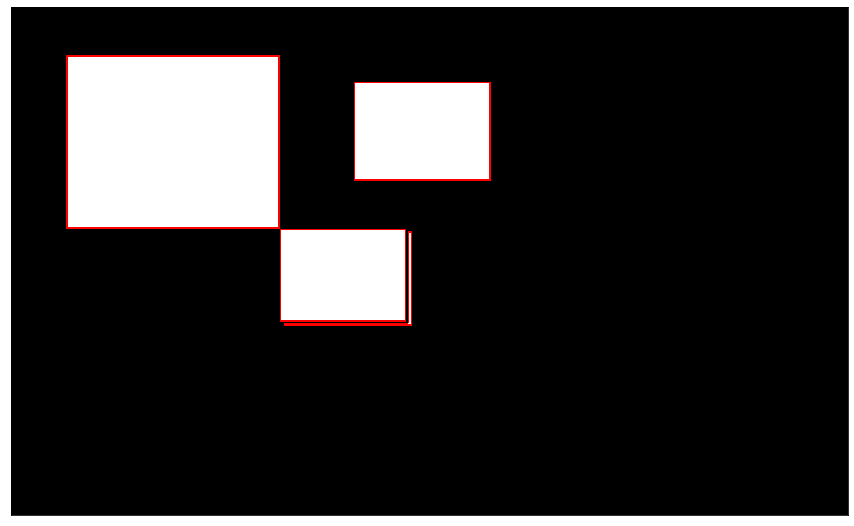

In [15]:
# Exemplo de encontrando componentes conexos

import cv2
mask = cv2.imread("retangulos_mask.bmp", cv2.IMREAD_GRAYSCALE)
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

# Desenha os contornos e vermelho
mask_cor = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
cv2.drawContours(mask_cor, contours, contourIdx=-1, color=(0,0,255))
plt.figure(figsize=(15,15))
mostra_fig(mask_cor)


### Medidas dos contornos

A partir dos contornos, podemos tirar uma série de medidas como:
- **Área:** número de pixels petencentes ao contorno, calculada com `cv2.contourArea(contour)`
- **Centro de massa:** linha e coluna do centro de masssa do contorno

**Exemplo:** calcula o componente conexo de maior área e desenha seu contorno de verde e o ponto do centro de massa com um círculo azul
 

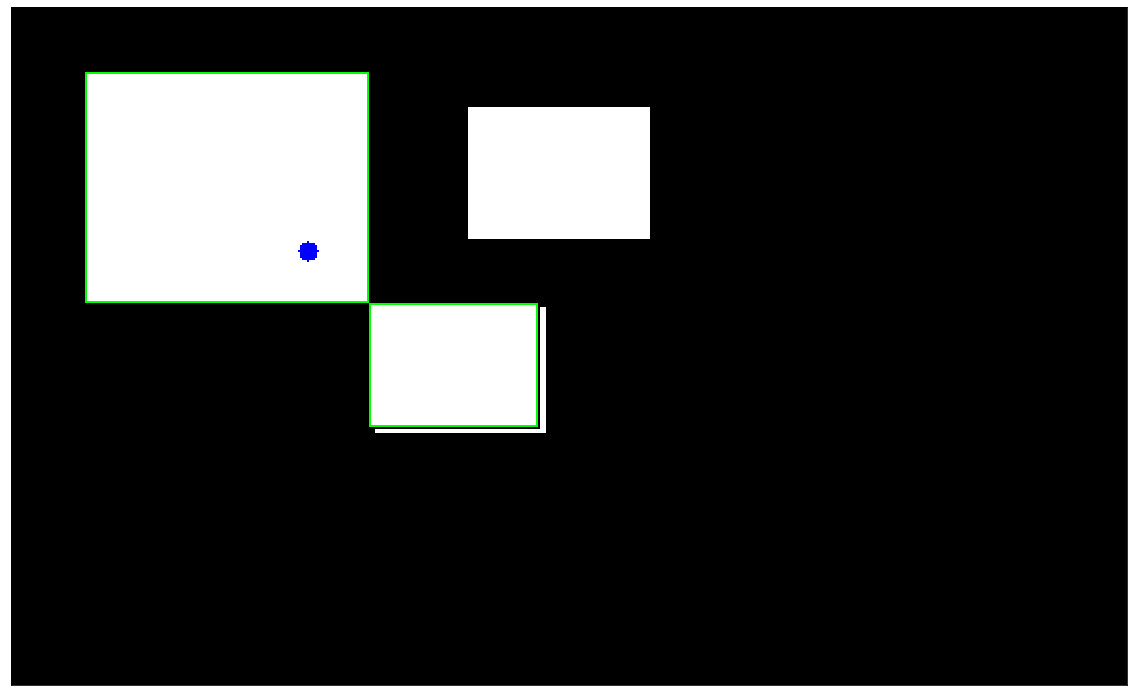

In [20]:
mask = cv2.imread("retangulos_mask.bmp", cv2.IMREAD_GRAYSCALE)
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

# encontra o contorno de maior área
maior_area = 0
contorno_maior_area = None
# O laço de repetição do Python funciona como o for-each do Java
for contorno in contours:
    # Calcula a área
    area = cv2.contourArea(contorno)
    if area > maior_area:
        maior_area = area 
        contorno_maior_area = contorno

# Transforma a máscara em imagem colorida
mask_cor = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
# Desenha o maior contornos de verde
cv2.drawContours(mask_cor, [contorno_maior_area], contourIdx=0, color=(0,255,0))
# Calcula e mostra o centro de massa
centro_x = contorno_maior_area[:,:,0].mean()
centro_y = contorno_maior_area[:,:,1].mean()
cv2.circle(mask_cor, (int(centro_x), int(centro_y)), radius=5, color=(255,0,0), thickness=-1) 

plt.figure(figsize=(20,20))
mostra_fig(mask_cor)


### Pratique: 
Carregar a imagem `pingpong.jpg` e desenhar o contorno e o centro de massa da bolinha laranja. Imprima também a sua área na tela.
